In [17]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind_from_stats
import random

In [2]:
trainingDataFilename = 'trainingSet.csv'
testDataFilename = 'testSet.csv'

In [3]:
DEPTH_LIMIT = 8
SAMPLE_LIMIT = 50
class TreeNode(object):
    def __init__(self, class_label, lineage):
        self.val = class_label
        self.lineage = lineage
        self.left = None
        self.right = None

    def is_leaf(self):
        return ((self.left is None) or (self.right is None))

    def expand(self, data, features, modelIdx, depth):
        class_label = int(len(data[data['decision'] == 1]) > len(data[data['decision'] == 0]))
        if modelIdx == 1 or modelIdx == 2:
            available_features = [f for f in features if f not in self.lineage]
        else:
            rf_sample = [i for i in range(0, int(len(features)))]
            np.random.shuffle(rf_sample)
            rf_sample = rf_sample[0:int(np.sqrt(len(features)))]
            rf_features = []
            for i in rf_sample:
                rf_features.append(features[i])
            #print rf_features
            available_features = [f for f in rf_features if f not in self.lineage]
        if len(self.lineage) < depth - 1 and len(data) > 50:
            ginis = {k: get_gini_gain(data, k) for k in available_features}
            best_feature = max(ginis, key=ginis.get)
            left_data = data[data[best_feature] == 0]
            right_data = data[data[best_feature] == 1]
            
            self.val = best_feature
            self.left = TreeNode(class_label, self.lineage + [best_feature])
            self.left.expand(left_data, features, modelIdx, depth=depth)
            self.right = TreeNode(class_label, self.lineage + [best_feature])
            self.right.expand(right_data, features, modelIdx, depth=depth)
        else:
            self.val = class_label
            
def gini(data):
    total = len(data)
    pos = 1.0 * len(data[data['decision'] == 1])/(1.0 * total) if len(data[data['decision'] == 1]) > 0 else 0.0
    neg = 1.0 * len(data[data['decision'] == 0])/(1.0 * total) if len(data[data['decision'] == 0]) > 0 else 0.0
    return 1.0 - pos * pos - neg * neg

def get_gini_gain(data, attr):
    total = len(data)
    pos = 1.0 * len(data[data[attr] == 1])/(1.0 * total) if len(data[data[attr] == 1]) > 0 else 0.0
    neg = 1.0 * len(data[data[attr] == 0])/(1.0 * total) if len(data[data[attr] == 0]) > 0 else 0.0
    gain = gini(data) - pos * gini(data[data[attr] == 1]) - neg * gini(data[data[attr] == 0])
    return gain

In [4]:
def decisionTree(trainingSet, testSet, keys, d):
    root = TreeNode(-1, [])
    root.expand(trainingSet, keys, 1, d)
    return root

def predict(node, data):
    if node.is_leaf():
        return node.val
    else:
        if data[node.val] == 0:
            return predict(node.left, data)
        else:
            return predict(node.right, data)

def get_accuracy_dt(root, trainingSet, testSet):
    count_train, total_train = 0, len(trainingSet)
    count_test, total_test = 0, len(testSet)
    
    train_labels = trainingSet['decision']
    test_labels = testSet['decision']
    
    trainingSet = trainingSet.drop('decision', axis=1)
    testSet = testSet.drop('decision', axis=1)
    
    predictions = []
    Y = np.array(test_labels)

    # Test accuracy
    i = 0
    for index, row in testSet.iterrows():
        predictions.append(predict(root, row))
        if int(predictions[i]) == Y[i]:
            count_test += 1         
        i += 1

    test_accuracy = 1.0 * count_test/total_test
    print 'Test Accuracy DT:', '%.2f' % test_accuracy
    return test_accuracy

In [5]:
def bagging(trainingSet, testSet, keys, d):
    root_bagging = []
    for i in range(30):
        train = trainingSet.sample(frac = 1.0, replace=True)
        root = TreeNode(-1, [])
        root.expand(train, keys, 2, d)
        root_bagging.append(root)
    return root_bagging

def get_accuracy_bagging(root, trainingSet, testSet):
    count_train, total_train = 0, len(trainingSet)
    count_test, total_test = 0, len(testSet)
    
    train_labels = trainingSet['decision']
    test_labels = testSet['decision']
    
    trainingSet = trainingSet.drop('decision', axis=1)
    testSet = testSet.drop('decision', axis=1)
    
    predictions = [0 for i in range(len(testSet))]
    Y = np.array(test_labels)

    # Test accuracy
    for r in root:
        i = 0
        for index, row in testSet.iterrows():
            predictions[i] += int(predict(r, row))
            i += 1

    for i in range(len(testSet)):
        if predictions[i] > 15 and Y[i] == 1:
            count_test += 1
        elif predictions[i] <= 15 and Y[i] == 0:
            count_test += 1

    test_accuracy = 1.0 * count_test/total_test
    print 'Test Accuracy BT:', '%.2f' % test_accuracy
    return test_accuracy

In [6]:
def randomForests(trainingSet, testSet, keys, d):
    root_rf = []
    for i in range(30):
        train = trainingSet.sample(frac = 1.0, replace=True)
        root = TreeNode(-1, [])
        root.expand(train, keys, 3, d)
        root_rf.append(root)
        #get_accuracy_dt(root, trainingSet, testSet)
    return root_rf
    
def get_accuracy_rf(root, trainingSet, testSet):
    count_train, total_train = 0, len(trainingSet)
    count_test, total_test = 0, len(testSet)
    
    train_labels = trainingSet['decision']
    test_labels = testSet['decision']
    
    trainingSet = trainingSet.drop('decision', axis=1)
    testSet = testSet.drop('decision', axis=1)
    
    predictions = [0 for i in range(len(testSet))]
    Y = np.array(test_labels)

    # Test accuracy
    for r in root:
        i = 0
        for index, row in testSet.iterrows():
            predictions[i] += int(predict(r, row))
            i += 1

    for i in range(len(testSet)):
        if predictions[i] > 15 and Y[i] == 1:
            count_test += 1
        elif predictions[i] <= 15 and Y[i] == 0:
            count_test += 1

    test_accuracy = 1.0 * count_test/total_test
    print 'Test Accuracy RF:', '%.2f' % test_accuracy
    return test_accuracy

In [7]:
trainingSet = pd.read_csv(trainingDataFilename)
testSet = pd.read_csv(testDataFilename)

keys = trainingSet.keys()
keys = keys.drop('decision')
f = [0.05,0.075,0.1,0.15,0.2]
trainingSet = trainingSet.sample(frac=1, random_state=18)

df_kfold = []
for i in range(10):
    df_kfold.append(trainingSet[i*260:(i+1)*260])

dt_res = {}
bagging_res = {}
rf_res = {}

for t_frac in f:
    dt_res[t_frac] = []
    bagging_res[t_frac] = []
    rf_res[t_frac] = []

In [8]:
for t_frac in f:
    print t_frac
    for i in range(10):
        # Partition the tarin and cv
        train_set_df = []
        
        for j in range(10):
            if j != i:
                train_set_df.append(df_kfold[j])
            else:
                test_set = df_kfold[j]
        
        train_set = pd.concat(train_set_df).sample(frac = t_frac, random_state=32)
        
        # Decision Tree
        root = decisionTree(train_set, test_set, keys, DEPTH_LIMIT)
        dt_res[t_frac].append(get_accuracy_dt(root, train_set, test_set))
        
        # Bagging
        root = bagging(train_set, test_set, keys, DEPTH_LIMIT)
        bagging_res[t_frac].append(get_accuracy_bagging(root, train_set, test_set))
        
        # Random Forest
        root = randomForests(train_set, test_set, keys, DEPTH_LIMIT)
        rf_res[t_frac].append(get_accuracy_rf(root, train_set, test_set))

0.05
Test Accuracy DT: 0.65
Test Accuracy BT: 0.67
Test Accuracy RF: 0.65
0.05
Test Accuracy DT: 0.71
Test Accuracy BT: 0.64
Test Accuracy RF: 0.65
0.05
Test Accuracy DT: 0.72
Test Accuracy BT: 0.72
Test Accuracy RF: 0.73
0.05
Test Accuracy DT: 0.68
Test Accuracy BT: 0.70
Test Accuracy RF: 0.72
0.05
Test Accuracy DT: 0.67
Test Accuracy BT: 0.70
Test Accuracy RF: 0.72
0.05
Test Accuracy DT: 0.68
Test Accuracy BT: 0.70
Test Accuracy RF: 0.72
0.05
Test Accuracy DT: 0.67
Test Accuracy BT: 0.73
Test Accuracy RF: 0.67
0.05
Test Accuracy DT: 0.69
Test Accuracy BT: 0.72
Test Accuracy RF: 0.68
0.075
Test Accuracy DT: 0.68
Test Accuracy BT: 0.68
Test Accuracy RF: 0.64
0.075
Test Accuracy DT: 0.70
Test Accuracy BT: 0.68
Test Accuracy RF: 0.66
0.075
Test Accuracy DT: 0.71
Test Accuracy BT: 0.75
Test Accuracy RF: 0.77
0.075
Test Accuracy DT: 0.75
Test Accuracy BT: 0.75
Test Accuracy RF: 0.74
0.075
Test Accuracy DT: 0.67
Test Accuracy BT: 0.72
Test Accuracy RF: 0.69
0.075
Test Accuracy DT: 0.71
Test

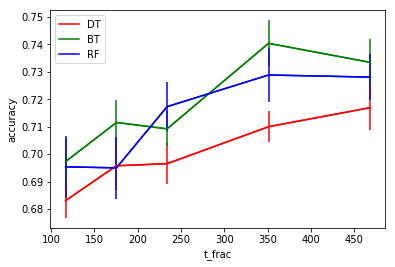

In [15]:
# Get avg accuracy
dt_avg = []
bagging_avg = []
rf_avg = []

# Get std error
dt_stdrr = []
bagging_stdrr = []
rf_stdrr = []
f = [0.05,0.075,0.1,0.15,0.2]

for t_frac in f:
    dt_avg.append(np.mean(dt_res[t_frac], axis = 0))
    dt_stdrr.append(np.std(dt_res[t_frac], axis = 0)/np.sqrt(10))
    bagging_avg.append(np.mean(bagging_res[t_frac], axis = 0))
    bagging_stdrr.append(np.std(bagging_res[t_frac], axis = 0)/np.sqrt(10))
    rf_avg.append(np.mean(rf_res[t_frac], axis = 0))
    rf_stdrr.append(np.std(rf_res[t_frac], axis = 0)/np.sqrt(10))

for i in range(len(f)):
    f[i] *= 9 * 260

#print lr_avg, svm_avg
    
fig = plt.figure()
plt.plot(f, dt_avg, color='red', label='DT')
plt.plot(f, bagging_avg, color='green', label='BT')
plt.plot(f, rf_avg, color='blue', label='RF')

plt.errorbar(f, dt_avg, dt_stdrr, color='red')
plt.errorbar(f, bagging_avg, bagging_stdrr, color='green')
plt.errorbar(f, rf_avg, rf_stdrr, color='blue')

plt.xlabel("t_frac")
plt.ylabel("accuracy");
plt.legend()

plt.savefig('./cv_frac.png')
plt.show()

In [22]:
print stats.ttest_ind(bagging_avg, rf_avg)

Ttest_indResult(statistic=0.4967647134373131, pvalue=0.6327165975663145)
